In [1]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = 'retina'

In [2]:
import scanpy as sc 
import numpy as np
import pandas as pd

In [3]:
import celloracle as co
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams['figure.dpi'] = 180


In [4]:
adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data/day3_lymph_rep_1.h5ad')
adata

AnnData object with n_obs × n_vars = 11567 × 3020
    obs: 'cluster', 'rctd_cluster', 'rctd_celltypes'
    uns: 'log1p'
    obsm: 'X_spatial', 'rctd_results', 'spatial'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

### Rerun CO if oracle object not saved

In [23]:
sc.tl.pca(adata, svd_solver='arpack')
adata

AnnData object with n_obs × n_vars = 11567 × 3020
    obs: 'cluster', 'rctd_cluster', 'rctd_celltypes'
    uns: 'log1p', 'pca'
    obsm: 'X_spatial', 'rctd_results', 'spatial', 'X_pca'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [24]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)

In [ ]:
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_diffmap')

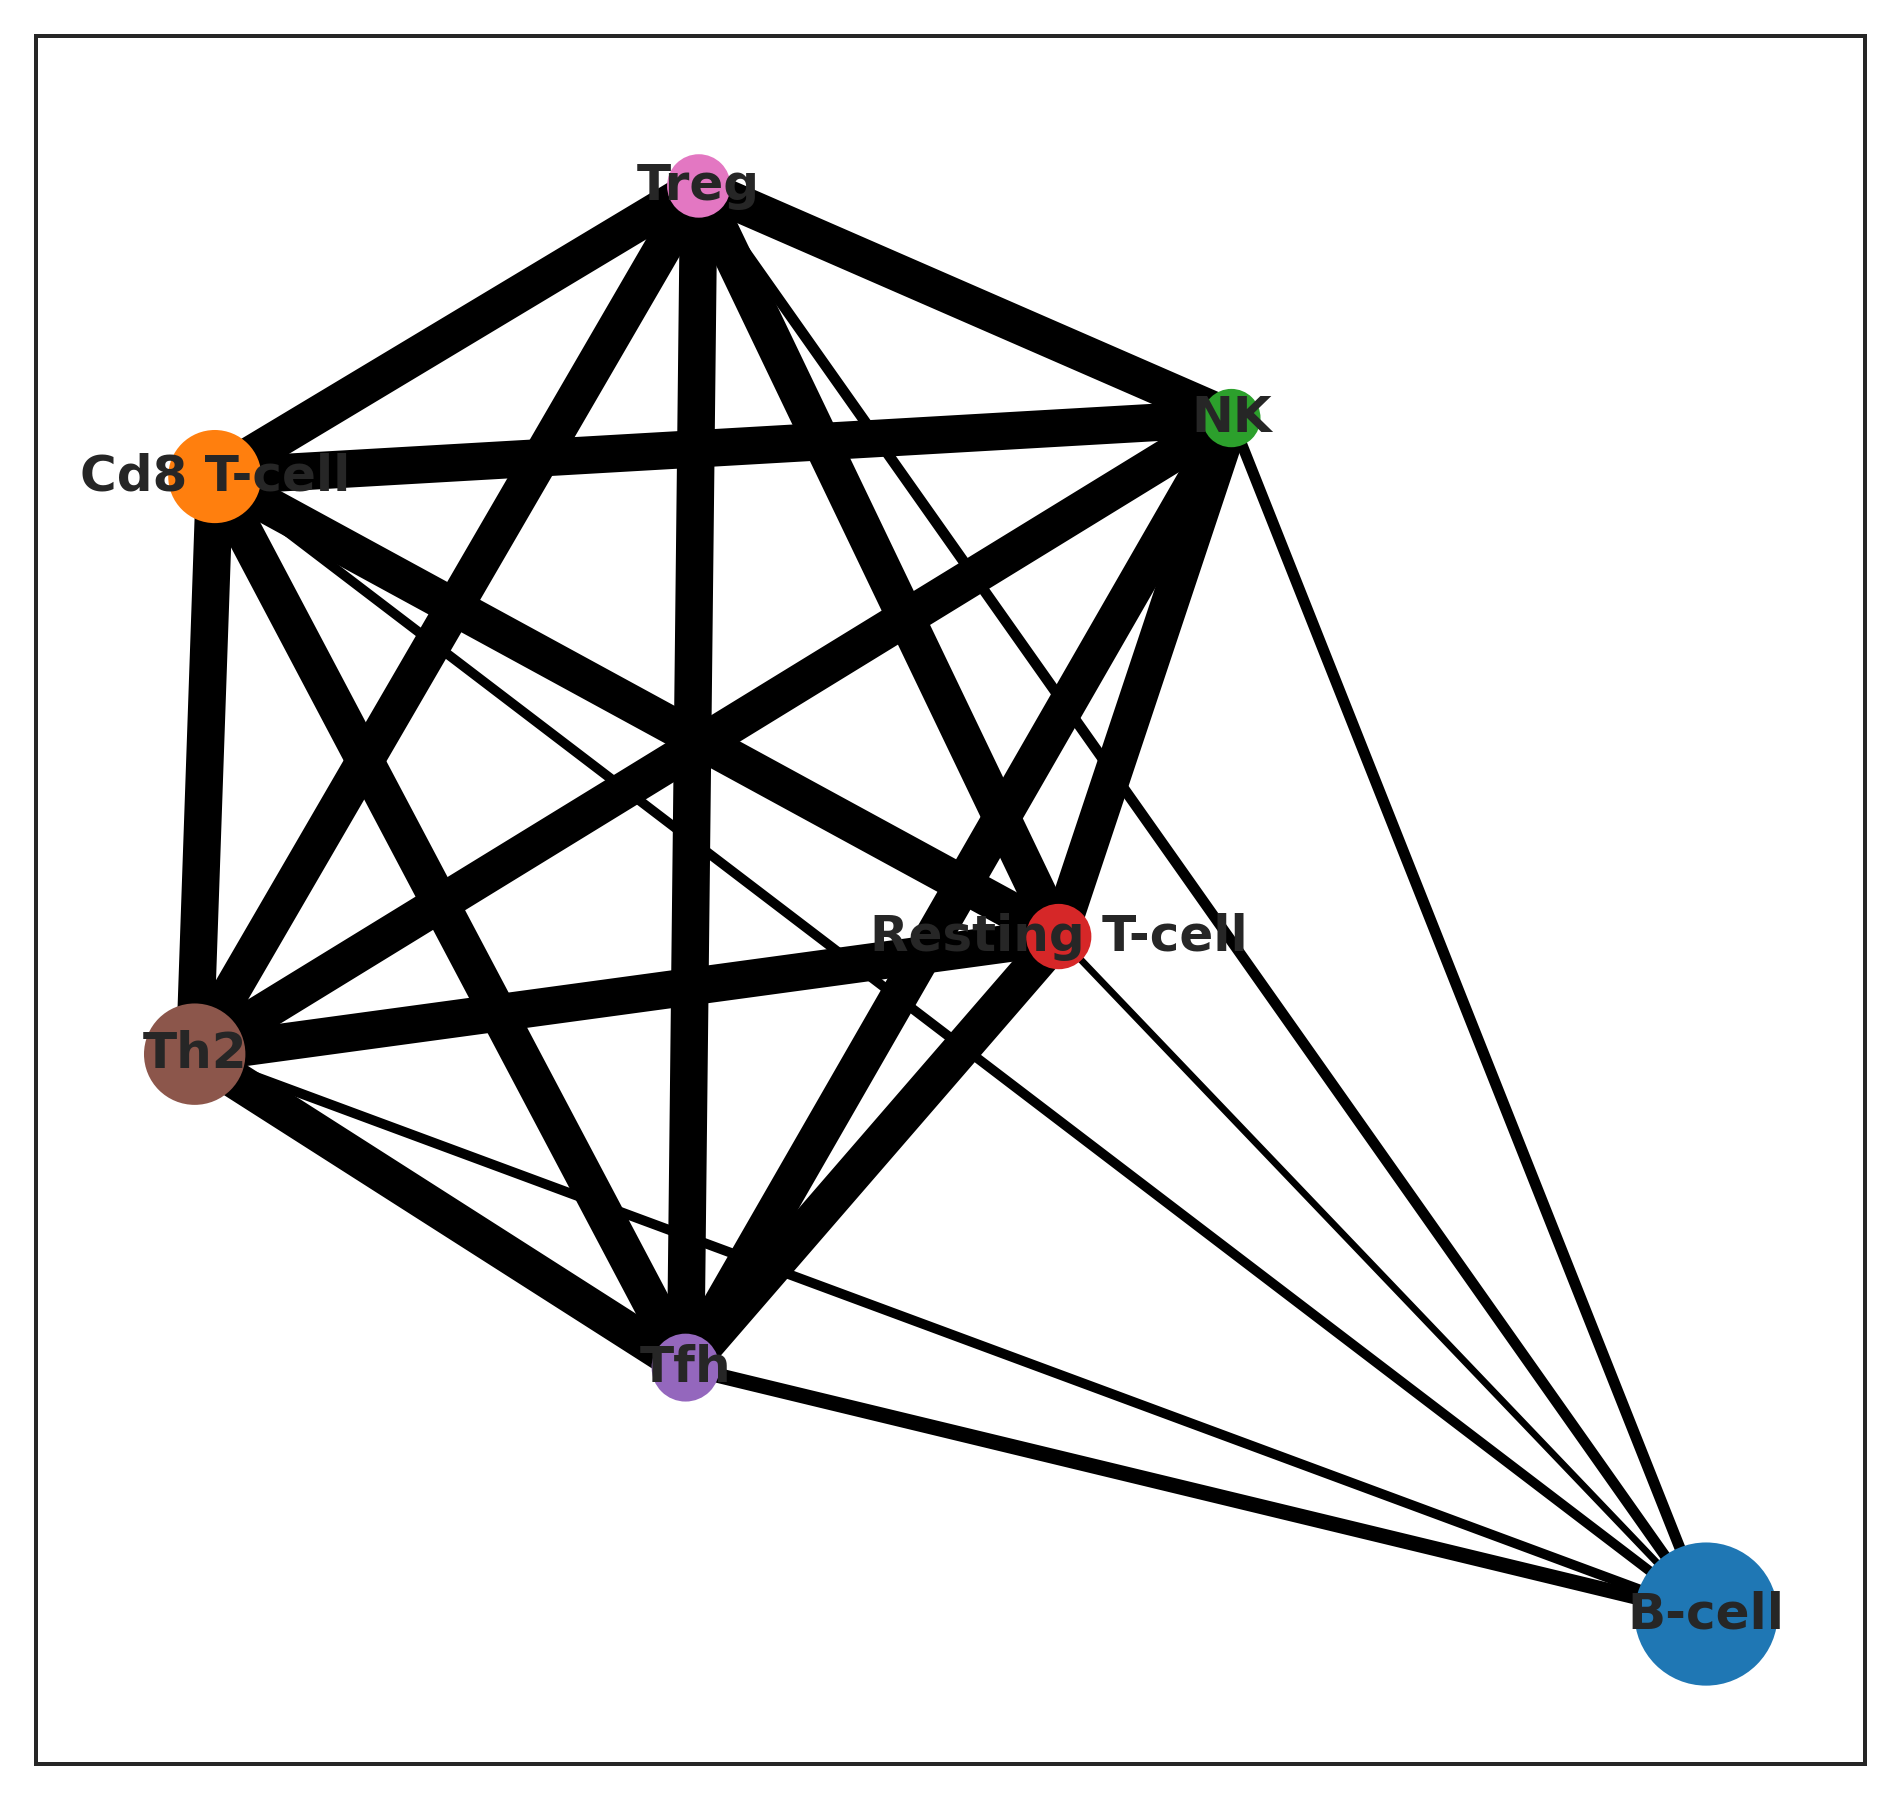

In [27]:
sc.tl.paga(adata, groups='rctd_celltypes')
plt.rcParams["figure.figsize"] = [6, 6]
sc.pl.paga(adata)

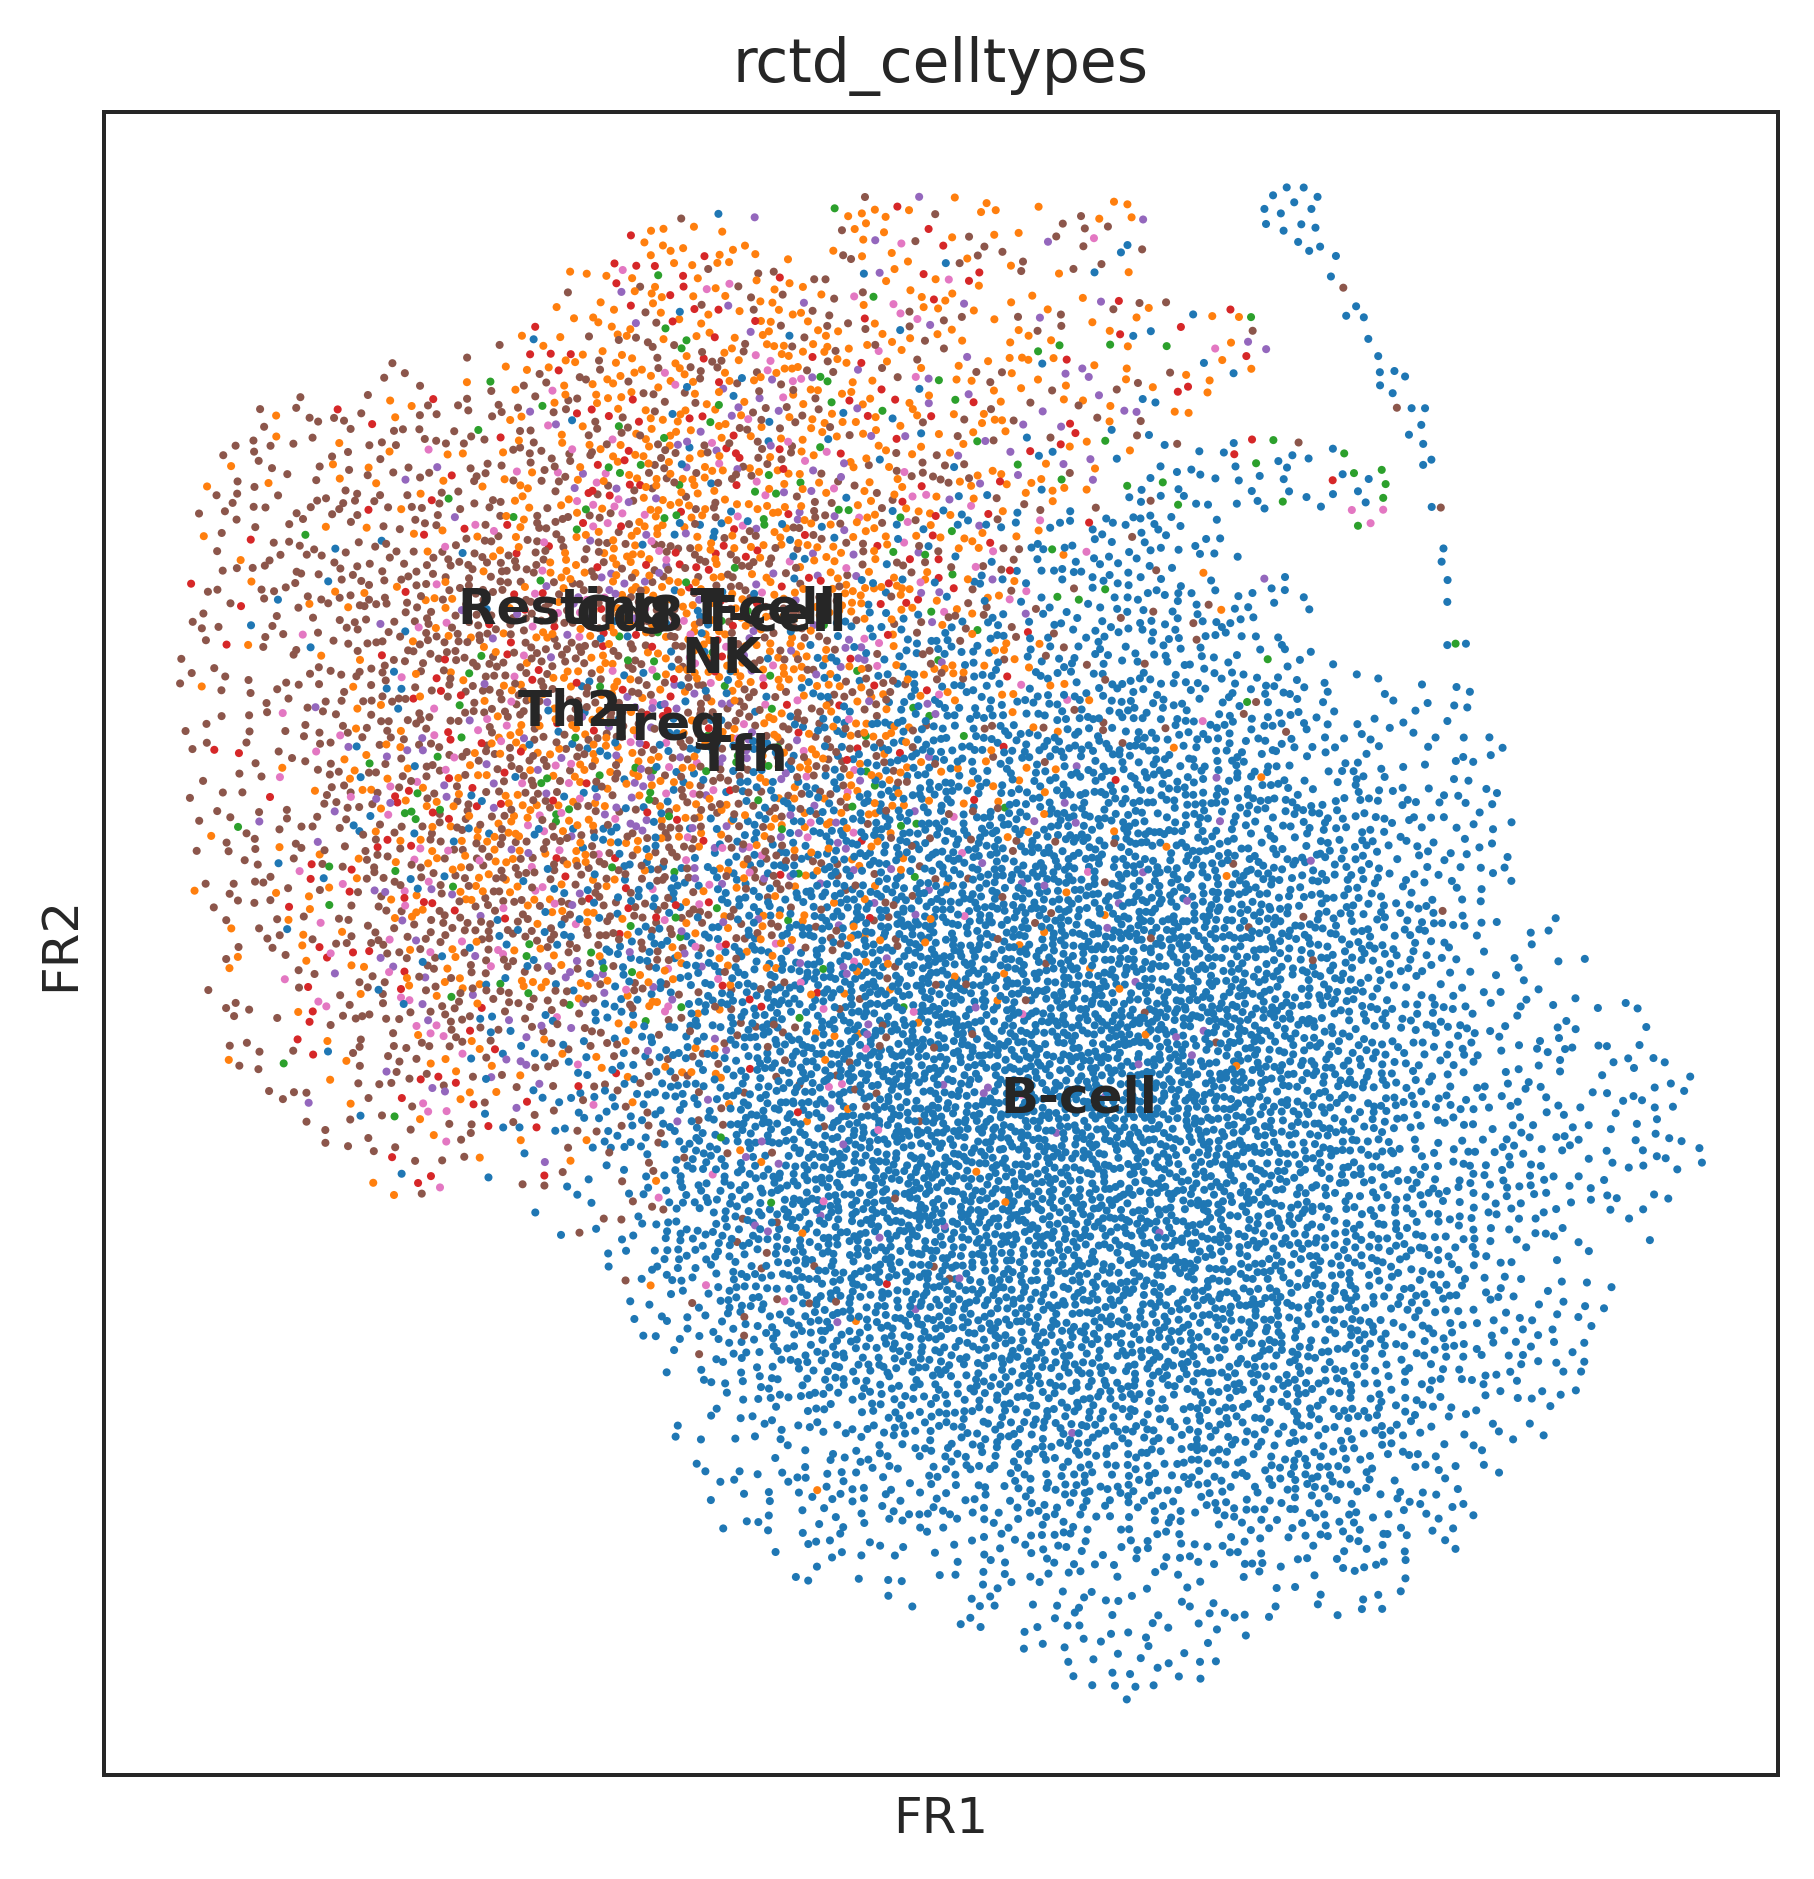

In [28]:
sc.tl.draw_graph(adata, init_pos='paga', random_state=123)
sc.pl.draw_graph(adata, color='rctd_celltypes', legend_loc='on data')

In [29]:
adata

AnnData object with n_obs × n_vars = 11567 × 3020
    obs: 'cluster', 'rctd_cluster', 'rctd_celltypes'
    uns: 'log1p', 'pca', 'neighbors', 'diffmap_evals', 'paga', 'rctd_celltypes_sizes', 'rctd_celltypes_colors', 'draw_graph'
    obsm: 'X_spatial', 'rctd_results', 'spatial', 'X_pca', 'X_diffmap', 'X_draw_graph_fr'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count', 'raw_count'
    obsp: 'distances', 'connectivities'

In [30]:
oracle = co.Oracle()

adata.X = adata.layers["raw_count"].copy()
oracle.import_anndata_as_raw_count(adata=adata,
                                   cluster_column_name="rctd_celltypes",
                                   embedding_name="X_draw_graph_fr")

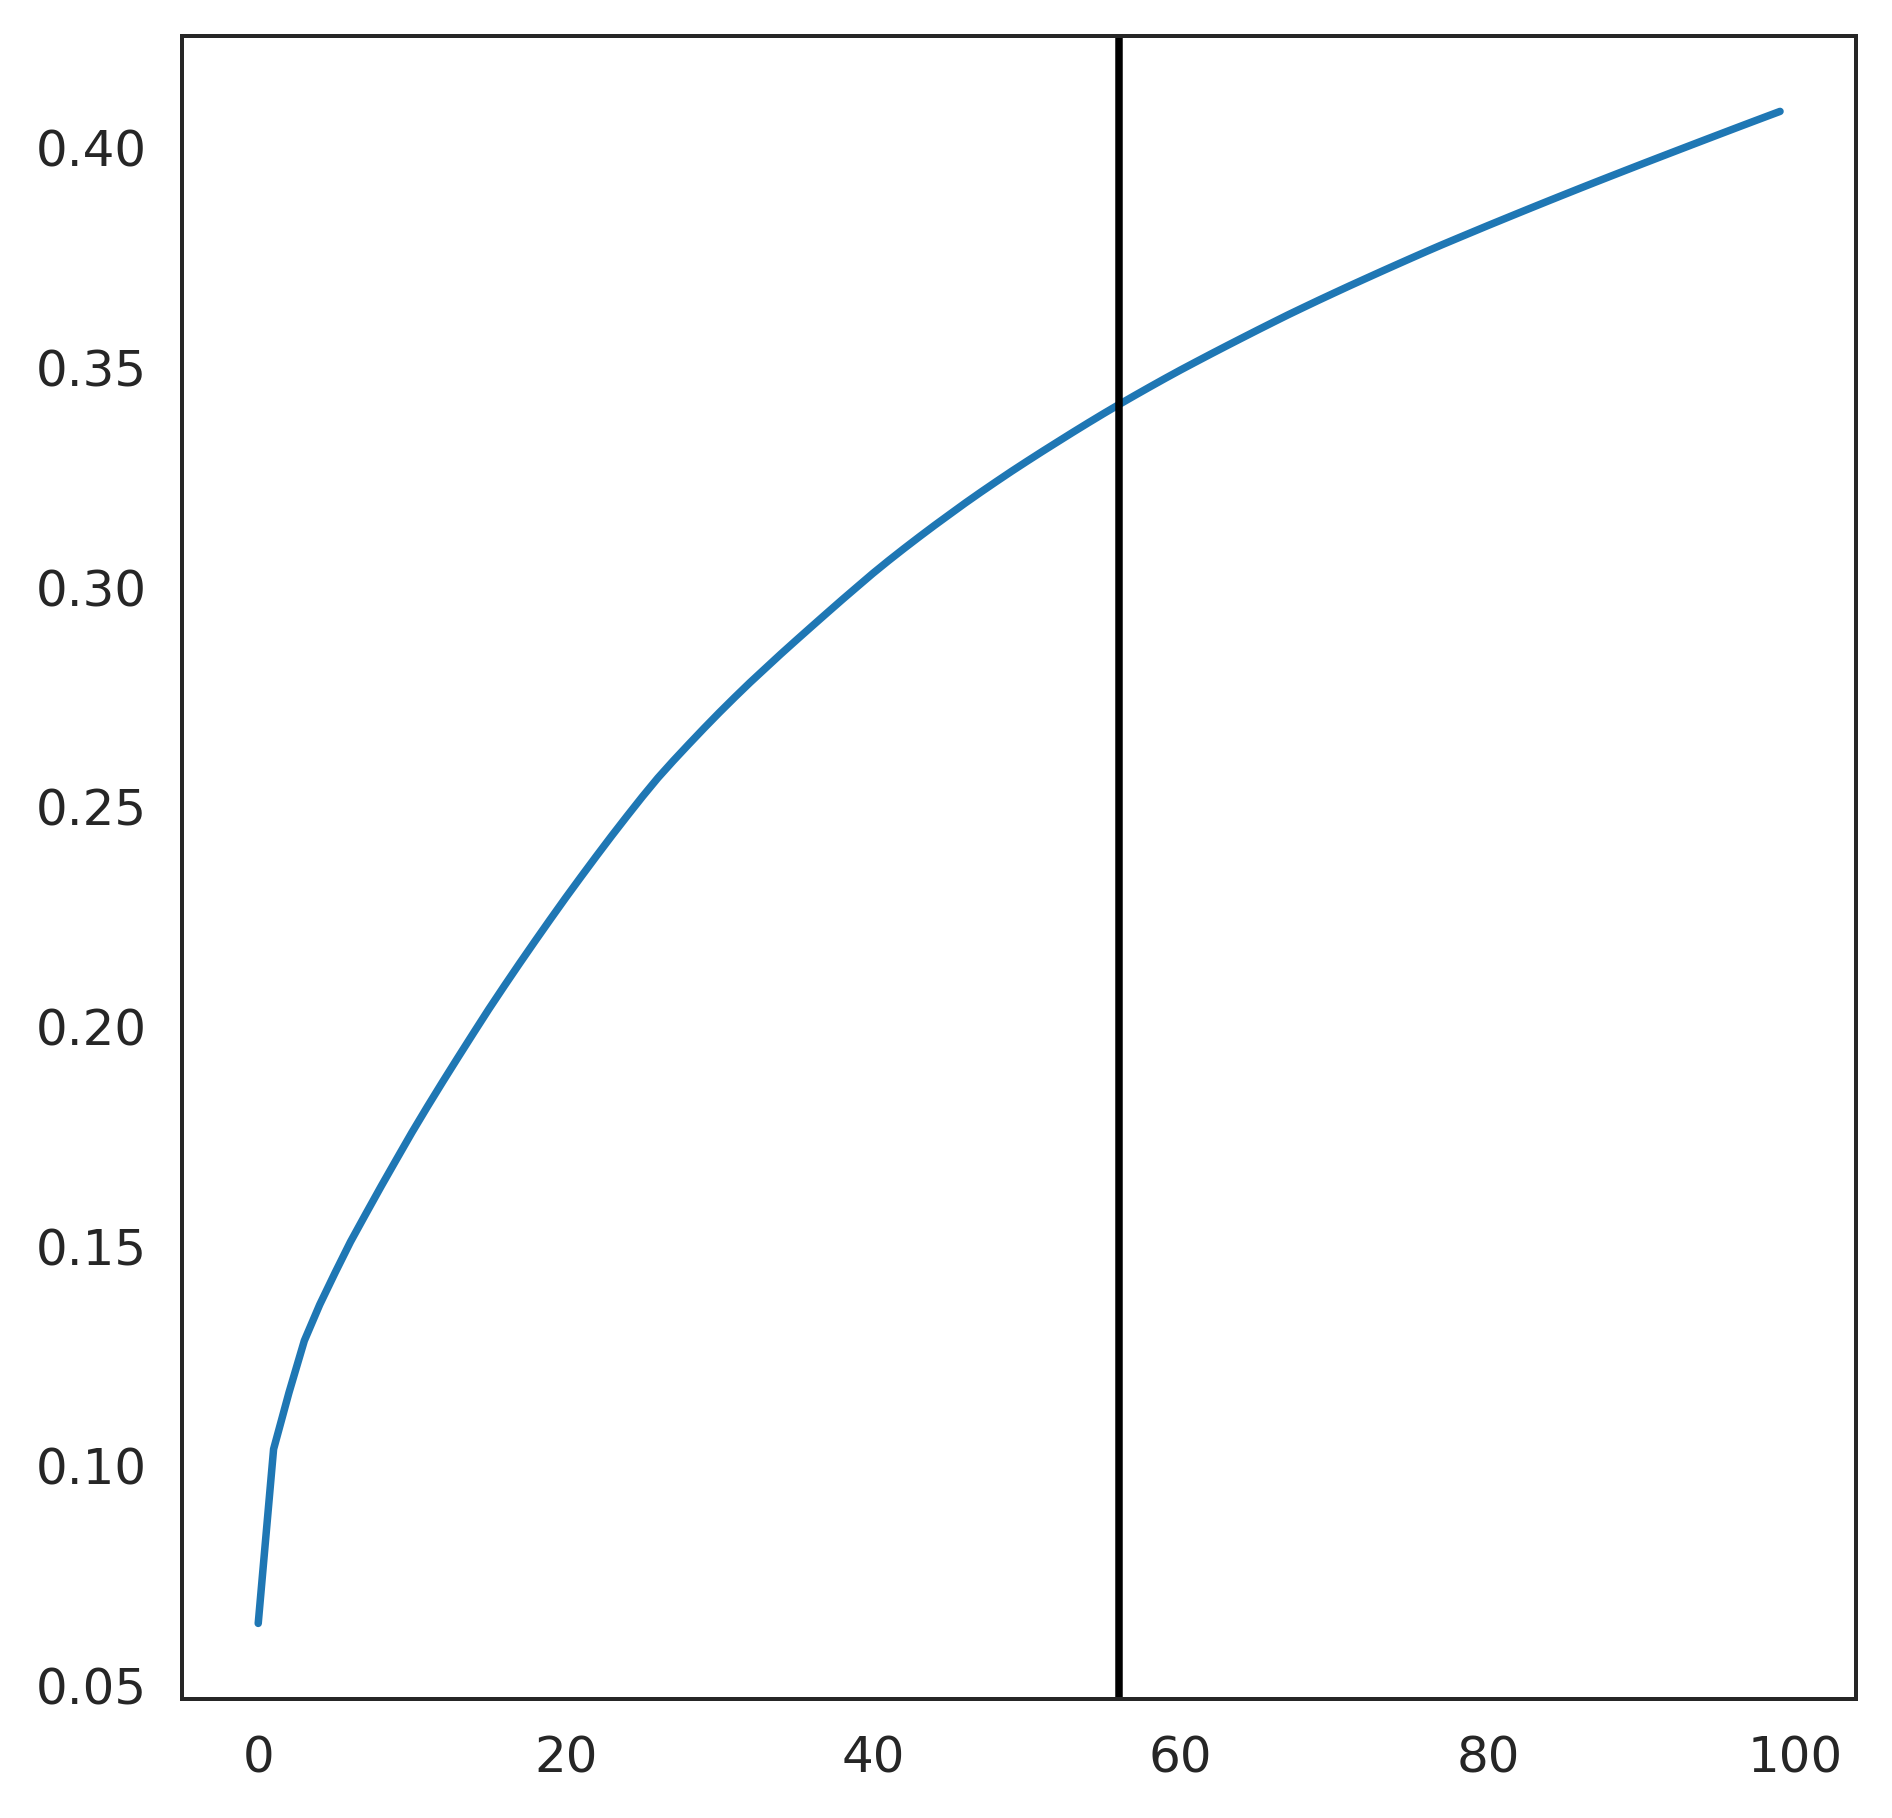

56


In [31]:
# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()

print(n_comps)
n_comps = min(n_comps, 50)

In [32]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

cell number is :11567
Auto-selected k is :289


In [33]:
oracle.knn_imputation(
    n_pca_dims=n_comps, 
    k=k, 
    balanced=True, 
    b_sight=k*8,
    b_maxl=k*4, 
    n_jobs=4
)

In [34]:
base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()
oracle.import_TF_data(TF_info_matrix=base_GRN)

In [48]:
%%time

links = oracle.get_links(
    cluster_name_for_GRN_unit="rctd_celltypes", 
    alpha=10,
    verbose_level=10, 
    # test_mode=True,
    # n_jobs=8
)

  0%|          | 0/7 [00:00<?, ?it/s]

Inferring GRN for B-cell...


  0%|          | 0/2405 [00:00<?, ?it/s]

Inferring GRN for Cd8 T-cell...


  0%|          | 0/2405 [00:00<?, ?it/s]

Inferring GRN for NK...


  0%|          | 0/2405 [00:00<?, ?it/s]

Inferring GRN for Resting T-cell...


  0%|          | 0/2405 [00:00<?, ?it/s]

Inferring GRN for Tfh...


  0%|          | 0/2405 [00:00<?, ?it/s]

Inferring GRN for Th2...


  0%|          | 0/2405 [00:00<?, ?it/s]

Inferring GRN for Treg...


  0%|          | 0/2405 [00:00<?, ?it/s]

CPU times: user 22min 26s, sys: 3.95 s, total: 22min 30s
Wall time: 49min 51s


In [49]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10,
                              use_cluster_specific_TFdict=True)

  0%|          | 0/7 [00:00<?, ?it/s]

In [50]:
oracle.to_hdf5("../../data/lymph_day3.celloracle.oracle")

In [54]:
links.to_hdf5(file_path="../../data/links.celloracle.links")

### Find macrostate transitions

In [5]:
import sys 
sys.path.append('../../src')

from spaceoracle.prophets import Prophet
from spaceoracle.judges import Judge

2025-01-20 12:19:09.624709: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
results_dir = '/ix/djishnu/shared/djishnu_kor11/results/lymph'
co_savedir = results_dir + '/co_simulated'
st_savedir = results_dir + '/st_simulated'

In [ ]:
goi = 'Pax5'

# nt_co = pd.DataFrame(oracle.adata.layers['imputed_count'], columns=oracle.adata.var_names)
nt_st = pd.DataFrame(adata.layers['imputed_count'], columns=adata.var_names)
# co = pd.DataFrame(np.load(co_savedir + '/Afp.npy'), columns=oracle.adata.var_names)
st = pd.DataFrame(np.load(st_savedir + f'/{goi}.npy'), columns=adata.var_names)

In [8]:
delta_X = st - nt_st
delta_X = delta_X.values
delta_X.shape

(11567, 3020)

In [ ]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color='rctd_celltypes', use_raw=False)

In [17]:
adata

AnnData object with n_obs × n_vars = 11567 × 3020
    obs: 'cluster', 'rctd_cluster', 'rctd_celltypes'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'rctd_celltypes_colors'
    obsm: 'X_spatial', 'rctd_results', 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count', 'raw_count'
    obsp: 'distances', 'connectivities'

In [103]:
judger = Judge(adata, annot='rctd_celltypes')


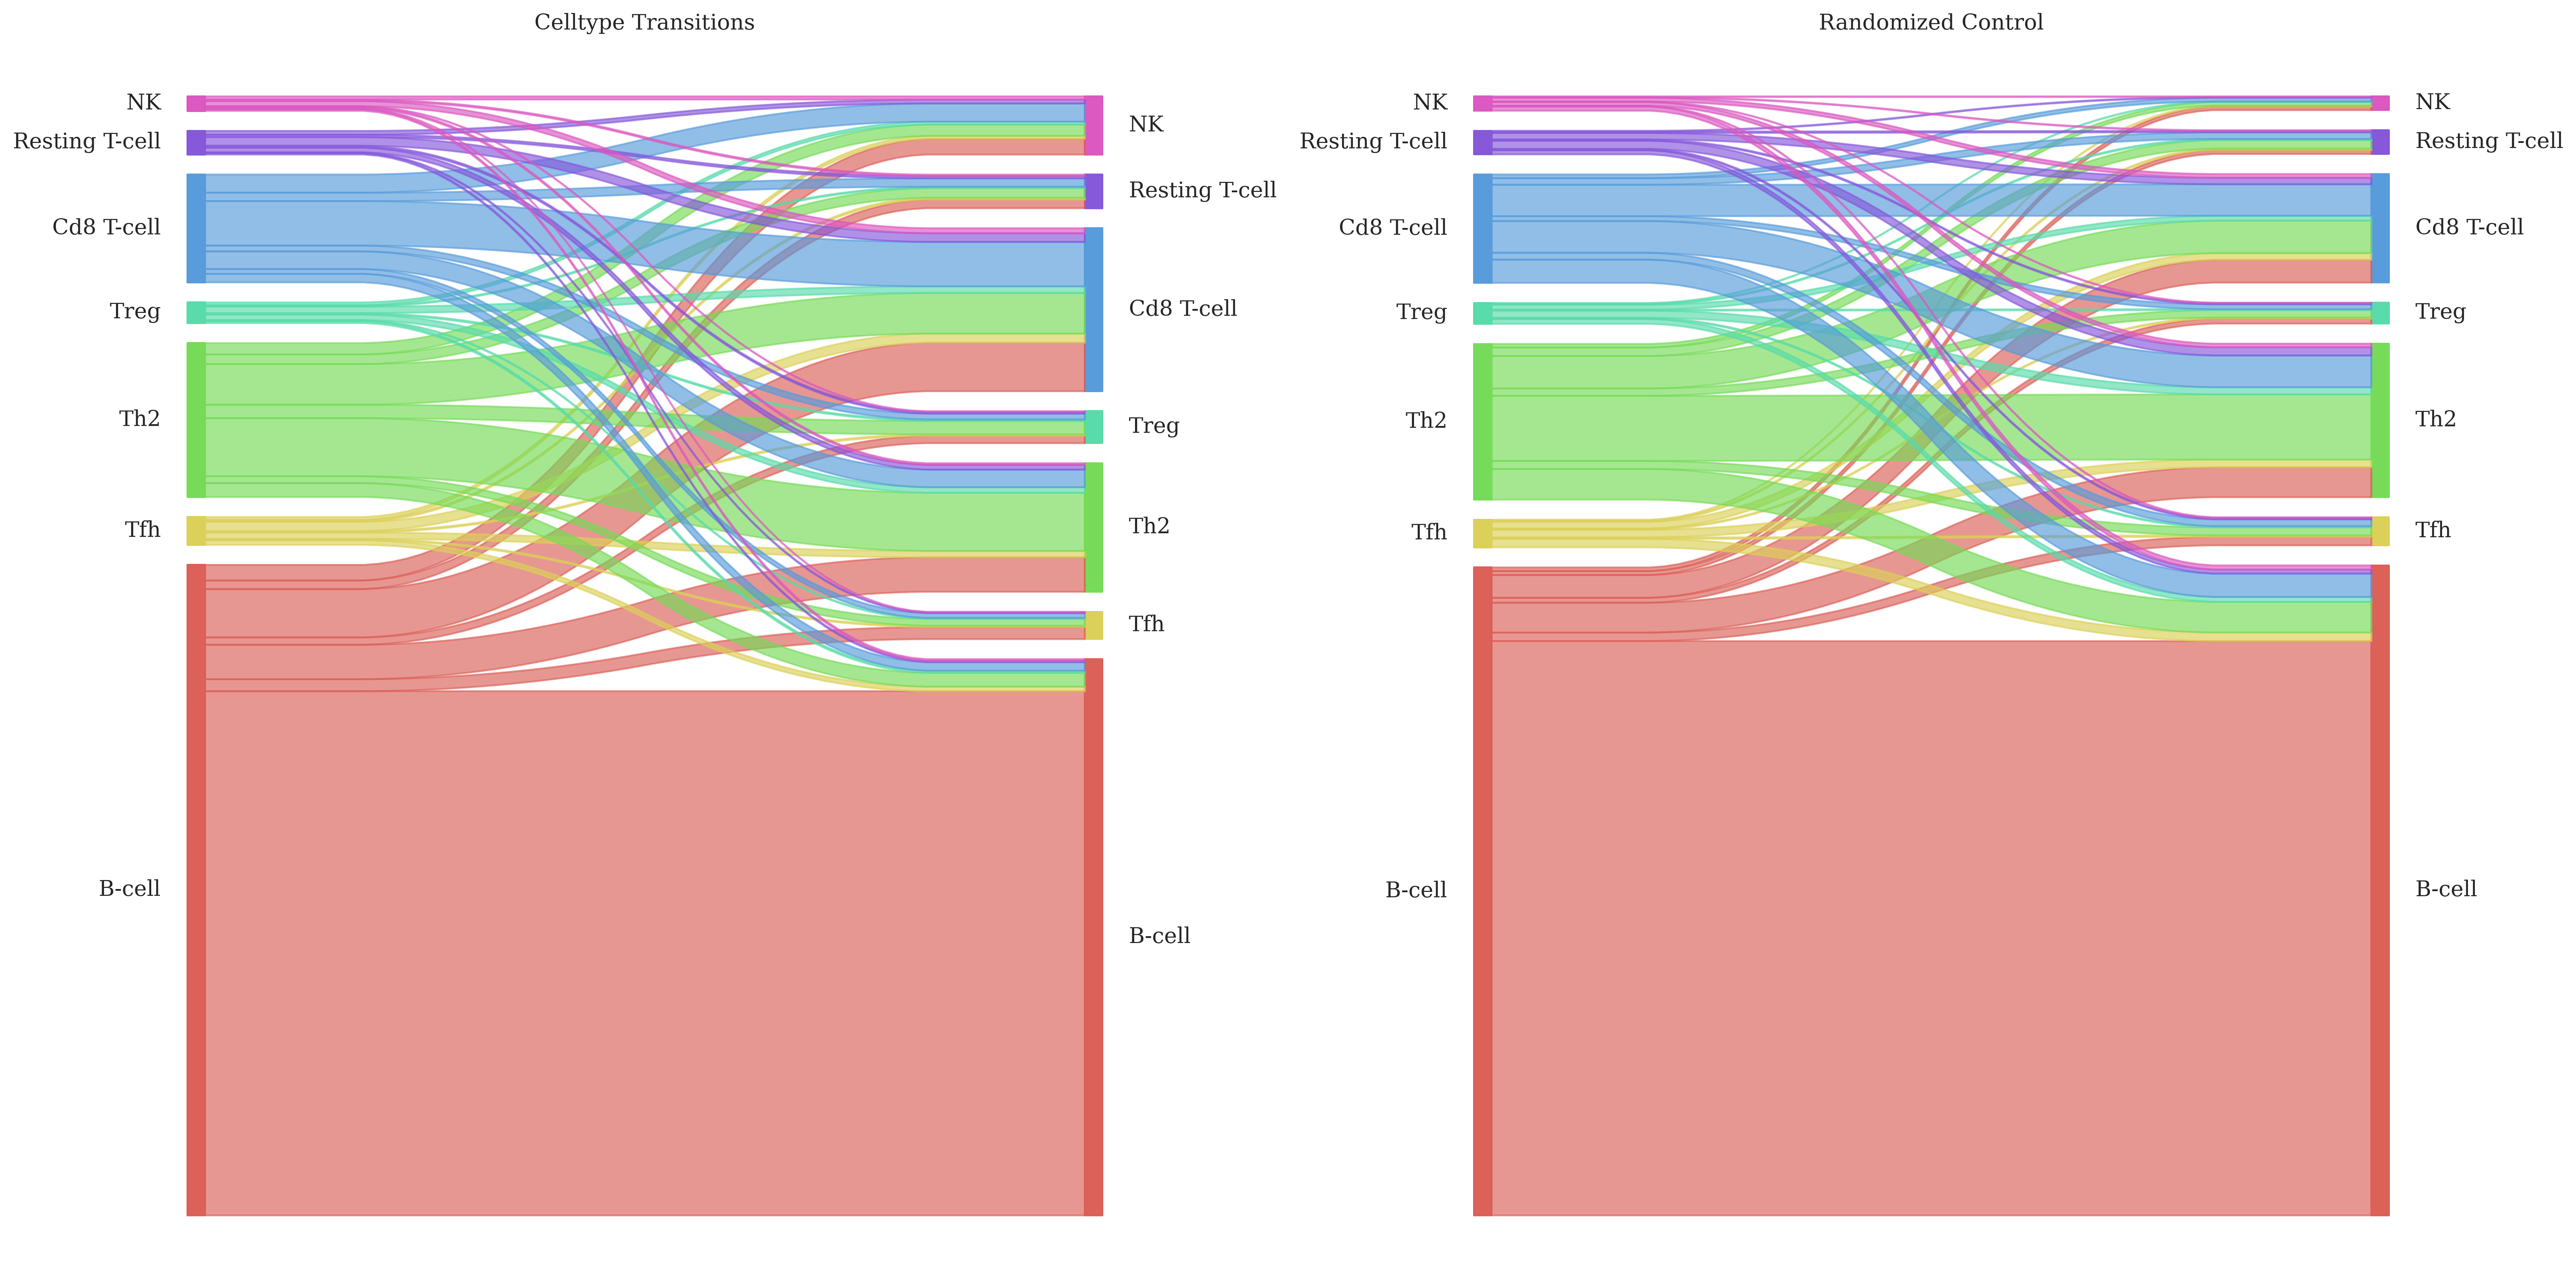

In [155]:
judger.plot_macrostate_change(
    adata=adata,
    delta_X=delta_X,
    annot='rctd_celltypes',
    embedding=adata.obsm['X_umap'],
    nn_transitions=100
)

In [191]:
from spaceoracle.plotting.niche import get_demographics

demo_df = get_demographics(adata, 'rctd_celltypes', radius=100)
demo_df

B-cell  Cd8 T-cell  NK  Resting T-cell  Tfh  Th2  Treg
AAAAAACGGTAGAT      35           0   1               0    0    0     0
AAAAAATCCGGCGA       1           6   1               3    2   19     5
AAAAACCGTCAGAC      62           0   0               0    0    1     0
AAAAACGCTCCGAC      61           0   0               0    1    0     0
AAAAAGCACGTGTT      70           0   0               0    0    0     0
...                ...         ...  ..             ...  ...  ...   ...
TTTTTTCGCGGCTA      48           1   0               0    2    0     0
TTTTTTGGGCTGGT       0          10   1               6    3   17     0
TTTTTTGTACCCAC      27           1   1               0    2   11     0
TTTTTTGTACGATT      13           6   1               1    2   12     1
TTTTTTTTGCTTTA      45           0   0               1    0    1     0

[11567 rows x 7 columns]

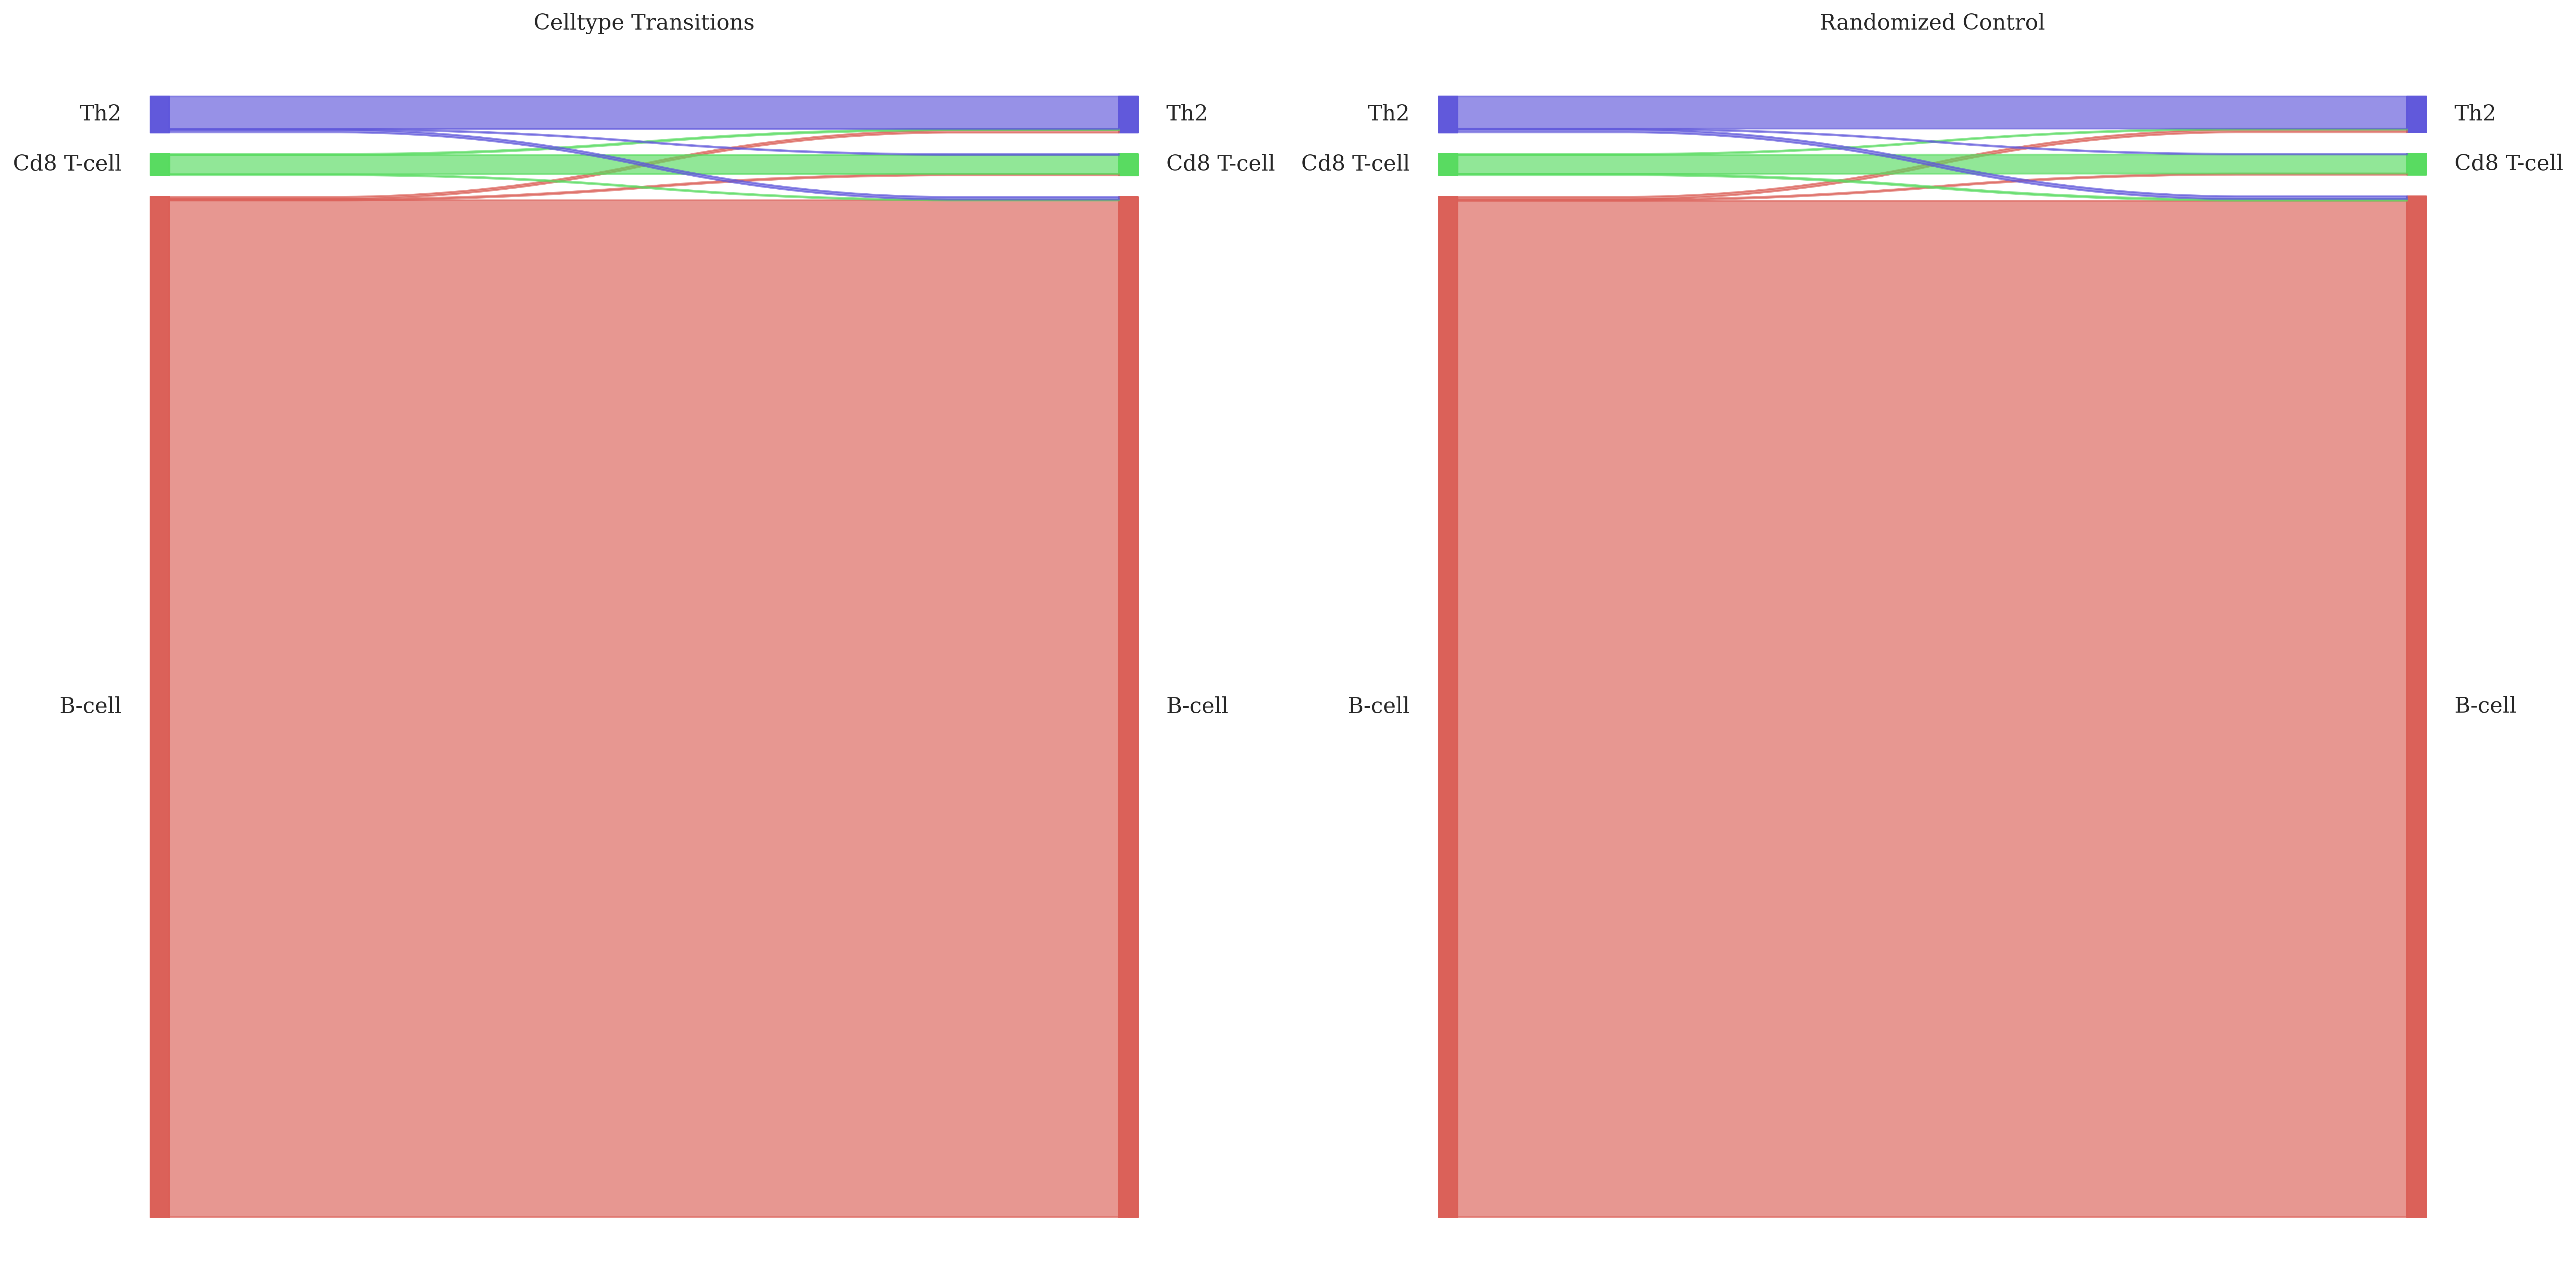

In [184]:
judger.plot_demographic_change(adata, delta_X, annot='rctd_celltypes', celltype='B-cell')

### Do comparison

In [188]:
oracle = co.load_hdf5("../../data/lymph_day3.celloracle.oracle")
links = co.load_hdf5(file_path="../../data/links.celloracle.links")

In [6]:
tfs = []
for cluster, df in links.links_dict.items():
    tfs.extend(df["source"].unique())

tfs = sorted(set(tfs))
len(tfs)

102

In [7]:
import sys 
sys.path.append('../../src')

In [8]:
from spaceoracle.prophets import Prophet

pythia = Prophet(
    adata=adata,
    models_dir='/ix/djishnu/shared/djishnu_kor11/models_v2',
    annot='rctd_cluster',
    annot_labels='rctd_celltypes'
)

pythia.compute_betas()

2025-01-16 00:49:51.168326: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
100%|██████████| 2000/2000 [02:37<00:00, 12.69it/s]


In [9]:
results_dir = '/ix/djishnu/shared/djishnu_kor11/results/lymph'
co_savedir = results_dir + '/co_simulated'
st_savedir = results_dir + '/st_simulated'

In [ ]:
tf = 'Ar'
print(tf)
pythia.perturb(tf, n_propagation=3)

Ar


Interactions: 100%|██████████| 2000/2000 [03:49<00:00,  8.71it/s]


In [66]:

np.save(st_savedir + f'/{tf}', pythia.adata.layers['simulated_count'])

In [67]:
oracle.simulate_shift(perturb_condition={tf: 0})
np.save(co_savedir + f'/{tf}', oracle.adata.layers['simulated_count'])

In [ ]:
from spaceoracle.judges import Judge
judger = Judge(adata)

2025-01-15 22:59:28.314720: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
st_sim_adata = judger.create_sim_adata(
    pythia.adata.layers['imputed_count'], 
    pythia.adata.layers['simulated_count']
)

st_deg_df = judger.get_expected_degs(st_sim_adata, ko=tf, show=30, save_path=results_dir + f'/comparison/degs/{tf}_ST.png')


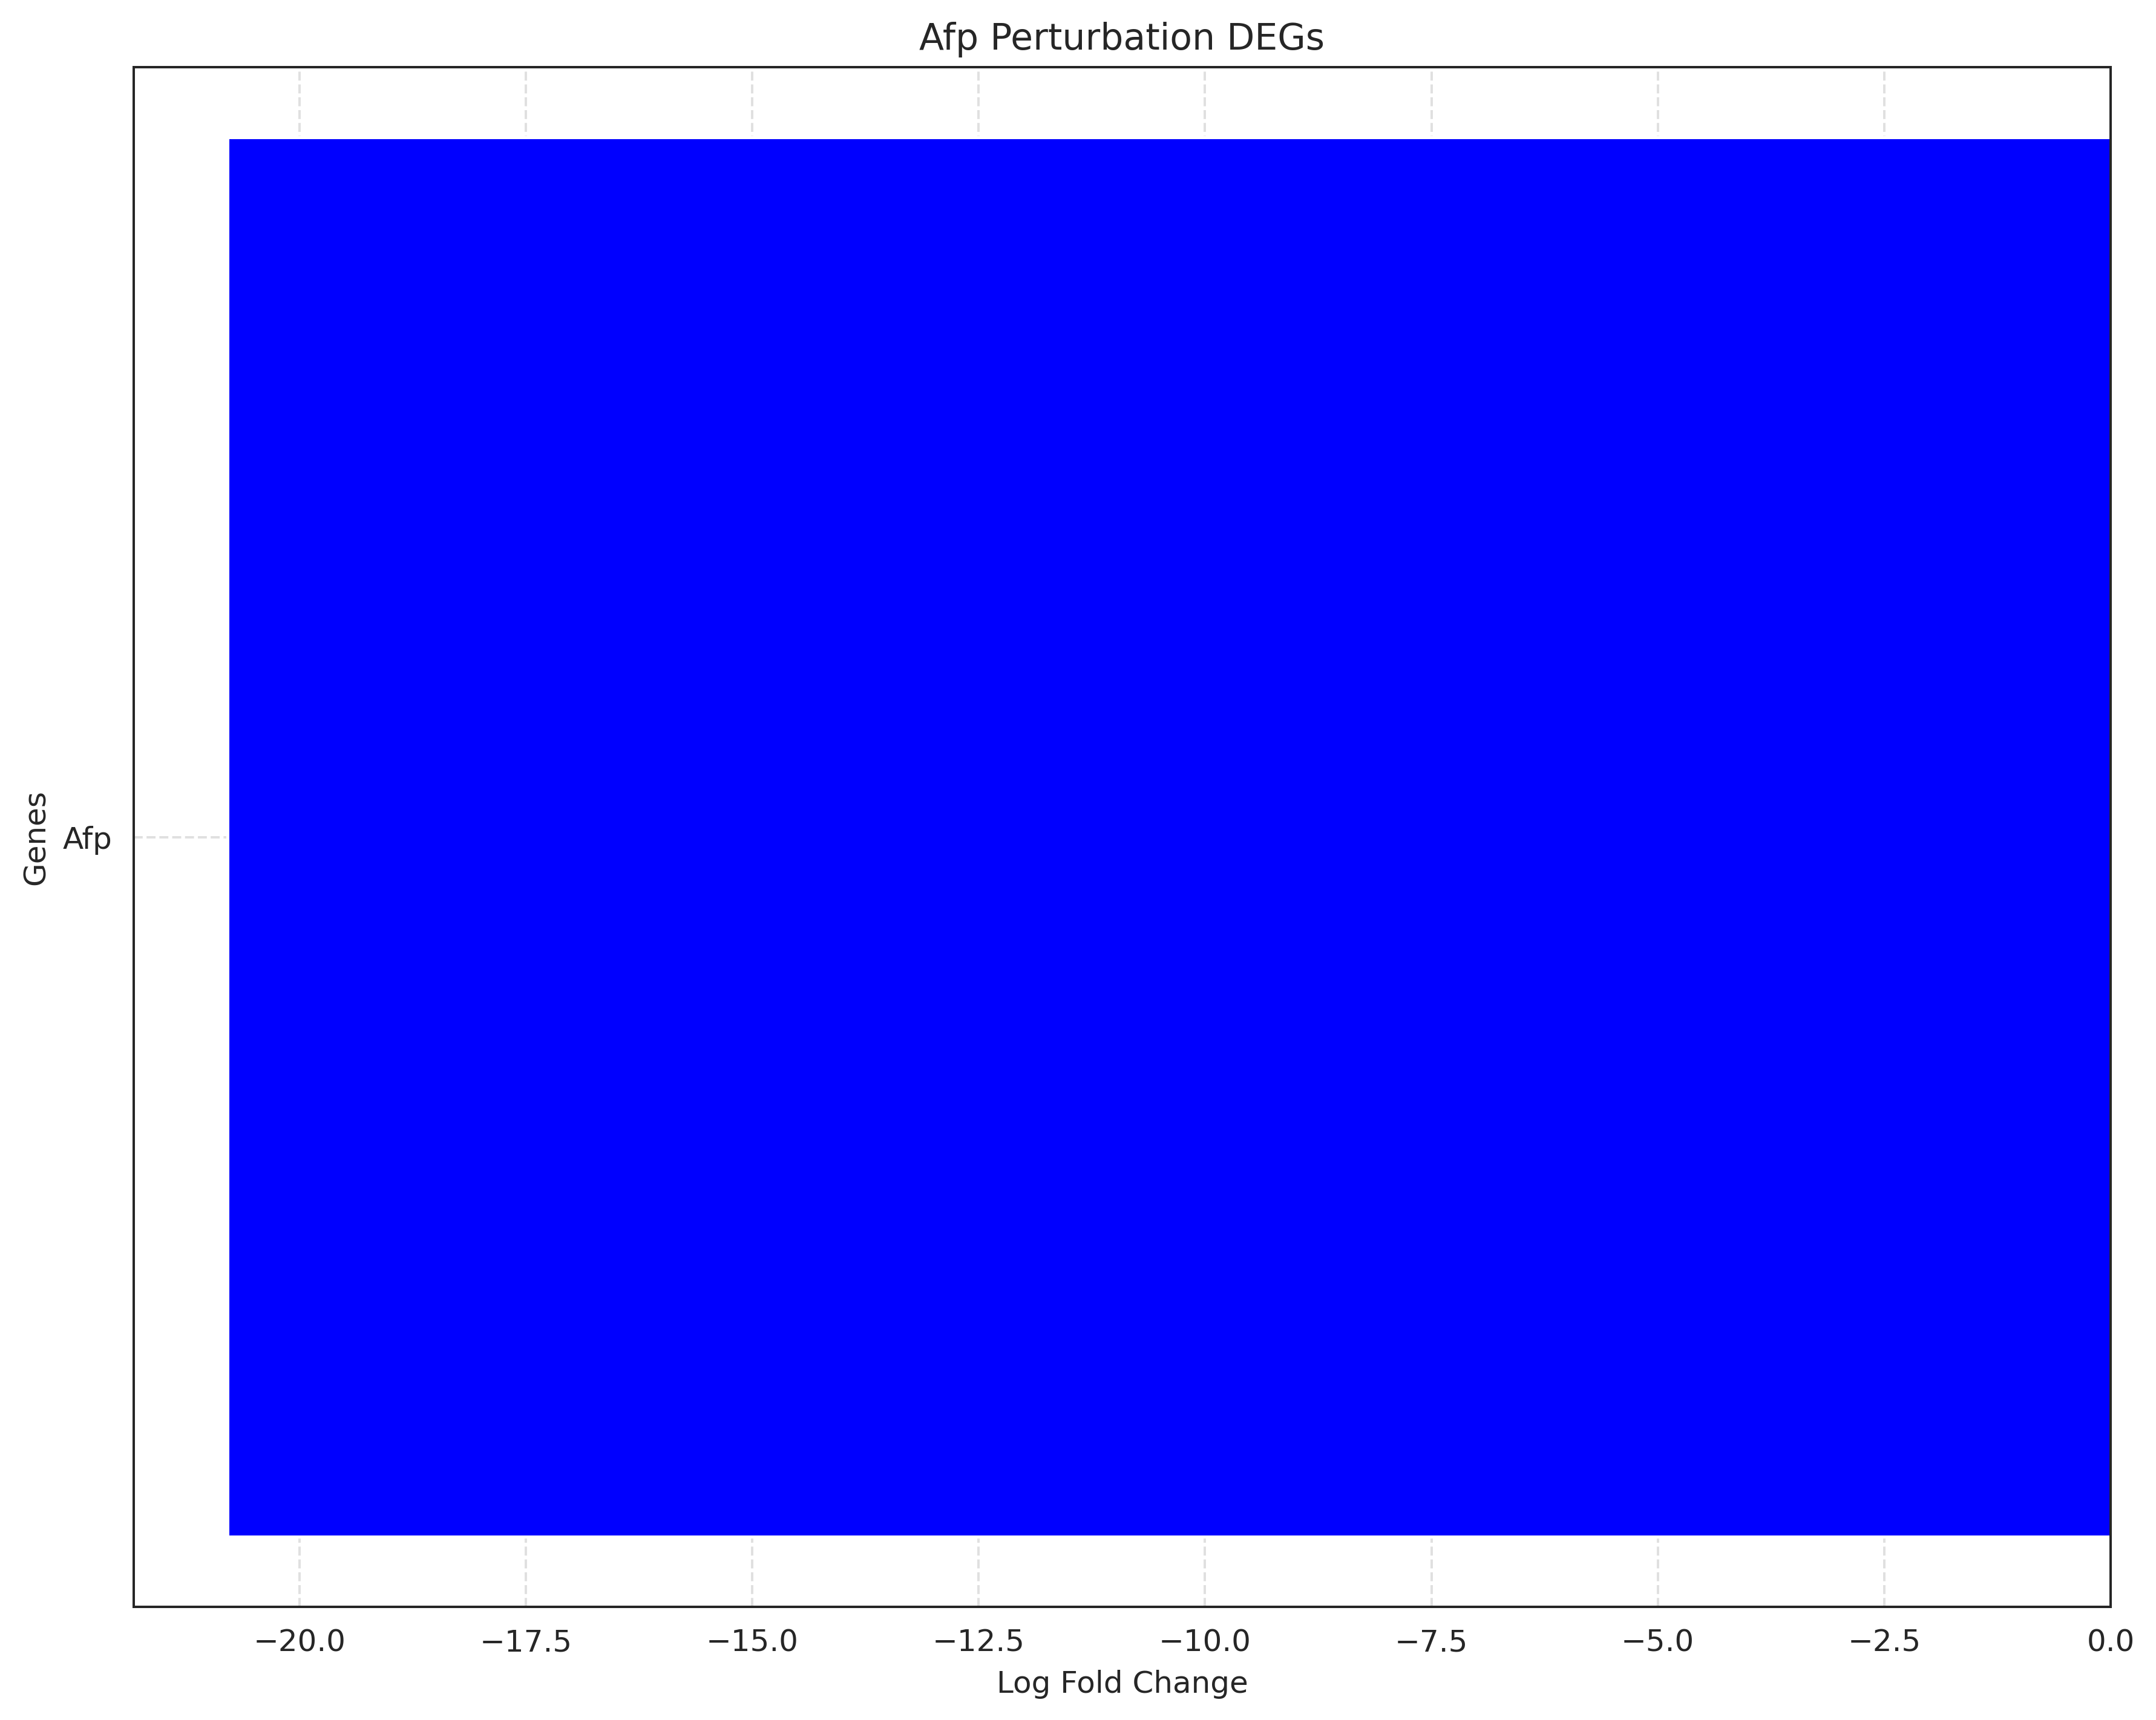

In [103]:
co_sim_adata = judger.create_sim_adata(
    oracle.adata.layers['imputed_count'], 
    oracle.adata.layers['simulated_count']
)

co_deg_df = judger.get_expected_degs(co_sim_adata, tf, show=30, save_path=results_dir + f'/comparison/degs/{tf}_CO.png')

In [104]:
nt_co = pd.DataFrame(oracle.adata.layers['imputed_count'], columns=oracle.adata.var_names)
co = pd.DataFrame(oracle.adata.layers['simulated_count'], columns=oracle.adata.var_names)
nt_st = pd.DataFrame(pythia.adata.layers['imputed_count'], columns=oracle.adata.var_names)
st = pd.DataFrame(pythia.adata.layers['simulated_count'], columns=oracle.adata.var_names)

In [189]:
# results_dir = '/ix/djishnu/shared/djishnu_kor11/results/lymph'
# co_savedir = results_dir + '/co_simulated'
# st_savedir = results_dir + '/st_simulated'


# nt_co = pd.DataFrame(oracle.adata.layers['imputed_count'], columns=oracle.adata.var_names)
# nt_st = pd.DataFrame(adata.layers['imputed_count'], columns=oracle.adata.var_names)
# co = pd.DataFrame(np.load(co_savedir + '/Afp.npy'), columns=oracle.adata.var_names)
# st = pd.DataFrame(np.load(st_savedir + '/Afp.npy'), columns=oracle.adata.var_names)

In [194]:
tf = 'Afp'
judger.plot_delta_corr(co=co, nt=nt_st, pred=st, ko=tf, save_path=results_dir + f'/comparison/delta_corr/{tf}.png')

In [201]:
co_sim_adata = judger.create_sim_adata(
    nt_co,
    co)

In [ ]:
sc.tl.rank_genes_groups(st_sim_adata, 'status', groups=['ko'], reference='wt')
sc.get.rank_genes_groups_df(st_sim_adata, group='ko').sort_values(by='logfoldchanges', ascending=False)

In [202]:
sc.tl.rank_genes_groups(co_sim_adata, 'status', groups=['ko'], reference='wt')
sc.get.rank_genes_groups_df(co_sim_adata, group='ko').sort_values(by='logfoldchanges', ascending=False)


... storing 'rctd_celltypes' as categorical


names     scores  logfoldchanges     pvals  pvals_adj
0        Cnr2   0.006216    9.484621e-05  0.995041        1.0
1      Gtf2f1   0.003878    3.697056e-05  0.996906        1.0
2       Spag7   0.003549    3.081760e-05  0.997168        1.0
3      Col4a1   0.000846    1.135680e-05  0.999325        1.0
4       Napsa   0.000030    4.460199e-07  0.999976        1.0
...       ...        ...             ...       ...        ...
3016  S100a13  -0.005391   -5.077594e-05  0.995699        1.0
3015      Id2  -0.004592   -7.489223e-05  0.996336        1.0
3017     Ppig  -0.008570   -8.915089e-05  0.993162        1.0
3018  Chordc1  -0.014837   -1.496831e-04  0.988162        1.0
3019      Afp -87.498413   -2.079031e+01  0.000000        0.0

[3020 rows x 5 columns]

In [23]:
results_dir = '/ix/djishnu/shared/djishnu_kor11/results/lymph'
co_savedir = results_dir + '/co_simulated'
st_savedir = results_dir + '/st_simulated'


nt_co = pd.DataFrame(oracle.adata.layers['imputed_count'], columns=oracle.adata.var_names)
nt_st = pd.DataFrame(adata.layers['imputed_count'], columns=oracle.adata.var_names)
co = pd.DataFrame(np.load(co_savedir + '/Bach2.npy'), columns=oracle.adata.var_names)
st = pd.DataFrame(np.load(st_savedir + '/Bach2.npy'), columns=oracle.adata.var_names)

In [35]:
st['Bach2']

0        0.000894
1        0.000894
2        0.000894
3        0.000894
4        0.000894
           ...   
11562    0.000894
11563    0.000894
11564    0.000894
11565    0.000894
11566    0.000894
Name: Bach2, Length: 11567, dtype: float64

In [34]:
nt_st['Bach2']

0        0.029909
1        0.018250
2        0.038584
3        0.045740
4        0.025813
           ...   
11562    0.025266
11563    0.031116
11564    0.021223
11565    0.032894
11566    0.024923
Name: Bach2, Length: 11567, dtype: float64

In [32]:
(st-nt_st)['Bach2']

0       -0.029016
1       -0.017356
2       -0.037691
3       -0.044847
4       -0.024919
           ...   
11562   -0.024373
11563   -0.030223
11564   -0.020329
11565   -0.032001
11566   -0.024029
Name: Bach2, Length: 11567, dtype: float64